In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg
import math
from scipy import stats

In [2]:
# Initial inventory at Retailer, wholesaler, distributor, and manufaturer, assuming manufacturer has unlimited capacity (very high)
v_0 = np.array([100, 100, 100]) # initial inventory
t_horizon = 26
consumer_demand = np.random.normal(100, 5, t_horizon) # Normal with no back-order
#consumer_demand = np.random.normal(100, 10, t_horizon) # Normal with back-order
#consumer_demand = np.random.random(t_horizon) * 100 # Random
consumer_demand = np.trunc(consumer_demand)
consumer_demand

array([103., 104.,  94., 107.,  97., 108., 100., 105.,  97., 105.,  99.,
       105., 102.,  90.,  95.,  98.,  93.,  99., 103., 104.,  95., 104.,
       104., 103.,  89., 100.])

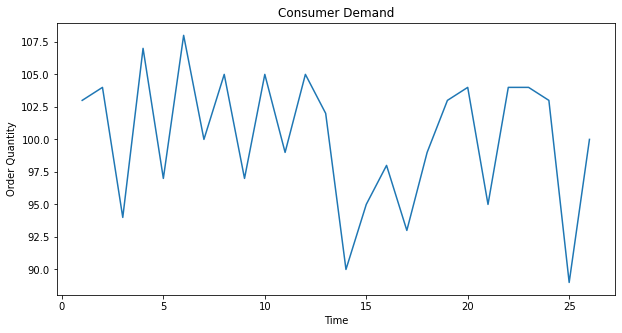

In [3]:
fig, ax = plt.subplots(figsize=(10, 5))

plt.plot(np.arange(1, 27, step=1), consumer_demand)
ax.set_xlabel("Time")
ax.set_ylabel("Order Quantity")
ax.set_title("Consumer Demand")
plt.show()

In [4]:
# At time t=1, without back-order
o_t_equals_one_retailer = consumer_demand[0]
o_t_equals_one_wholesaler = o_t_equals_one_retailer
o_t_equals_one_distributor = o_t_equals_one_wholesaler
o_t_equals_one_manufacturer = o_t_equals_one_distributor
o_t_equals_one = np.array([o_t_equals_one_retailer, o_t_equals_one_wholesaler, o_t_equals_one_distributor, o_t_equals_one_manufacturer])
o_t_equals_one

array([103., 103., 103., 103.])

In [5]:
# Define an order function
# f = d^n(t) + [d^n(t) + d^n(t-1)]
def order_func1(d_t, d_t_minus_one, o_t_minus_one):
    o_t_minus_one_retailer = o_t_minus_one[0]
    o_t_minus_one_wholesaler = o_t_minus_one[1]
    o_t_minus_one_distributor = o_t_minus_one[2]
    
    o_t_retailer = d_t + (d_t - d_t_minus_one)
    o_t_wholesaler = o_t_retailer + (o_t_retailer - o_t_minus_one_retailer)
    o_t_distributor = o_t_wholesaler + (o_t_wholesaler - o_t_minus_one_wholesaler)
    #o_t_manufacturer = o_t_distributor + (o_t_distributor - o_t_minus_one_distributor)
    o_t = np.array([o_t_retailer, o_t_wholesaler, o_t_distributor])
    
    return o_t
# f = [d^n(t) + d^n(t-1)] / 2
def order_func2(d_t, d_t_minus_one, o_t_minus_one):
    o_t_minus_one_retailer = o_t_minus_one[0]
    o_t_minus_one_wholesaler = o_t_minus_one[1]
    o_t_minus_one_distributor = o_t_minus_one[2]
    
    o_t_retailer = (d_t + d_t_minus_one) / 2
    o_t_wholesaler = (o_t_retailer + o_t_minus_one_retailer) / 2
    o_t_distributor = (o_t_wholesaler + o_t_minus_one_wholesaler) / 2
    #o_t_manufacturer = o_t_distributor + (o_t_distributor - o_t_minus_one_distributor)
    o_t = np.array([o_t_retailer, o_t_wholesaler, o_t_distributor])
    
    return o_t
# f = d^n(t)
def order_func3(d_t):
    
    o_t_retailer = d_t
    o_t_wholesaler = o_t_retailer
    o_t_distributor = o_t_wholesaler
    #o_t_manufacturer = o_t_distributor + (o_t_distributor - o_t_minus_one_distributor)
    o_t = np.array([o_t_retailer, o_t_wholesaler, o_t_distributor])
    
    return o_t

# f = d^n(t) + [d^n(t) - v^n(t)]^+
def back_order_func(d_t, v_t):
    # inventory at the beginning of time t
    v_t_retailer = v_t[0]
    v_t_wholesaler = v_t[1]
    v_t_distributor = v_t[2]
    
    o_t_retailer = d_t + np.maximum(0, d_t - v_t_retailer)
    v_t_plus_one_retailer = v_t_retailer - d_t + o_t_retailer # retailer starting inventory for the next period
    
    o_t_wholesaler = o_t_retailer + np.maximum(0, o_t_retailer - v_t_wholesaler)
    v_t_plus_one_wholesaler = v_t_wholesaler - o_t_retailer + o_t_wholesaler
    
    o_t_distributor = o_t_wholesaler + np.maximum(0, o_t_wholesaler - v_t_distributor)
    v_t_plus_one_distributor = v_t_distributor - o_t_wholesaler + o_t_distributor
    #o_t_manufacturer = o_t_distributor + (o_t_distributor - o_t_minus_one_distributor)
    o_t = np.array([o_t_retailer, o_t_wholesaler, o_t_distributor])
    v_t_plus_one = np.array([v_t_plus_one_retailer, v_t_plus_one_wholesaler, v_t_plus_one_distributor])
    return o_t, v_t_plus_one


# Define a function to round up to the nearest 10
def roundup(x):
    return int(math.ceil(x / 10.0)) * 10

In [6]:
print(order_func1(consumer_demand[1], consumer_demand[0], o_t_equals_one))
print(order_func2(consumer_demand[1], consumer_demand[0], o_t_equals_one))
print(order_func3(consumer_demand[1]))
print(back_order_func(consumer_demand[0], v_0))

[105. 107. 111.]
[103.5   103.25  103.125]
[104. 104. 104.]
(array([106., 112., 124.]), array([103., 106., 112.]))


In [7]:
consumer_demand

array([103., 104.,  94., 107.,  97., 108., 100., 105.,  97., 105.,  99.,
       105., 102.,  90.,  95.,  98.,  93.,  99., 103., 104.,  95., 104.,
       104., 103.,  89., 100.])

In [8]:
order = np.zeros(3 * t_horizon).reshape((-1, 3)) # order array for each participant over time horizon
# uncomment "no back-order" lines when evaluating cases with no back-order and comment "back-order" lines
# uncomment "back-order" lines when evaluating cases with back-order and comment "no back-order" lines
for t in range(1, consumer_demand.size+1):
    if t == 1:
        o_t = o_t_equals_one[:3] # no back-order
        #o_t, v_t_plus_one = back_order_func(consumer_demand[0], v_0) # back-order
        
    else:
        #o_t = order_func1(consumer_demand[t-1], consumer_demand[t-2], o_t_minus_one) # no back-order
        o_t = order_func2(consumer_demand[t-1], consumer_demand[t-2], o_t_minus_one) # no back-order
        #o_t = order_func3(consumer_demand[t-1]) # no back-order
        # o_t, v_t_plus_one = back_order_func(consumer_demand[t-1], v_t) # back-order
    o_t = np.maximum(o_t, np.zeros(3))
    order[t-1, :] = o_t
    o_t_minus_one = o_t # no back-order
    #v_t = v_t_plus_one # back-order

In [9]:
order_including_consumer = np.block([consumer_demand.reshape((-1, 1)), order])

In [10]:
order_including_consumer

array([[103.   , 103.   , 103.   , 103.   ],
       [104.   , 103.5  , 103.25 , 103.125],
       [ 94.   ,  99.   , 101.25 , 102.25 ],
       [107.   , 100.5  ,  99.75 , 100.5  ],
       [ 97.   , 102.   , 101.25 , 100.5  ],
       [108.   , 102.5  , 102.25 , 101.75 ],
       [100.   , 104.   , 103.25 , 102.75 ],
       [105.   , 102.5  , 103.25 , 103.25 ],
       [ 97.   , 101.   , 101.75 , 102.5  ],
       [105.   , 101.   , 101.   , 101.375],
       [ 99.   , 102.   , 101.5  , 101.25 ],
       [105.   , 102.   , 102.   , 101.75 ],
       [102.   , 103.5  , 102.75 , 102.375],
       [ 90.   ,  96.   ,  99.75 , 101.25 ],
       [ 95.   ,  92.5  ,  94.25 ,  97.   ],
       [ 98.   ,  96.5  ,  94.5  ,  94.375],
       [ 93.   ,  95.5  ,  96.   ,  95.25 ],
       [ 99.   ,  96.   ,  95.75 ,  95.875],
       [103.   , 101.   ,  98.5  ,  97.125],
       [104.   , 103.5  , 102.25 , 100.375],
       [ 95.   ,  99.5  , 101.5  , 101.875],
       [104.   ,  99.5  ,  99.5  , 100.5  ],
       [10

In [11]:
order_min = np.min(order_including_consumer)
order_max = np.max(order_including_consumer)

order_min = roundup(order_min)
order_max = roundup(order_max)

order_min, order_max

(90, 110)

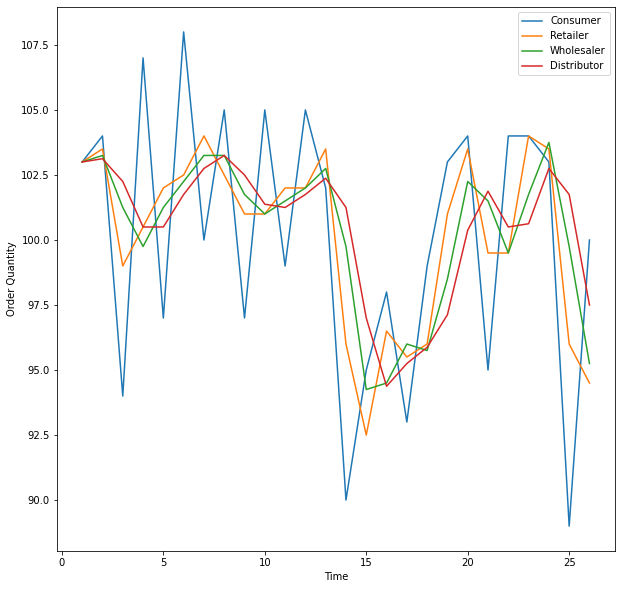

In [12]:
fig, ax = plt.subplots(figsize=(10, 10))

x_ticks = np.arange(1, t_horizon+1)
plt.plot(x_ticks, order_including_consumer[:, 0], label="Consumer")
plt.plot(x_ticks, order_including_consumer[:, 1], label="Retailer")
plt.plot(x_ticks, order_including_consumer[:, 2], label="Wholesaler")
plt.plot(x_ticks, order_including_consumer[:, 3], label="Distributor")
ax.set_xlabel("Time")
ax.set_ylabel("Order Quantity")
plt.legend()
plt.show()

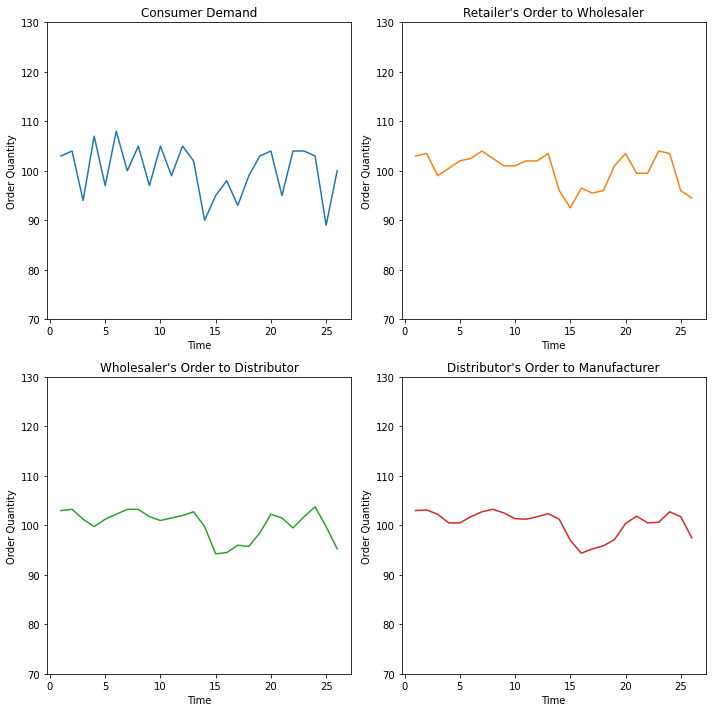

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0, 0].plot(x_ticks, order_including_consumer[:, 0])
axs[0, 0].set_title("Consumer Demand")
axs[0, 1].plot(x_ticks, order_including_consumer[:, 1], 'tab:orange')
axs[0, 1].set_title("Retailer's Order to Wholesaler")
axs[1, 0].plot(x_ticks, order_including_consumer[:, 2], 'tab:green')
axs[1, 0].set_title("Wholesaler's Order to Distributor")
axs[1, 1].plot(x_ticks, order_including_consumer[:, 3], 'tab:red')
axs[1, 1].set_title("Distributor's Order to Manufacturer")

for ax in axs.flat:
    ax.set(xlabel="Time", ylabel="Order Quantity")
    ax.set_ylim(order_min-20, order_max+20)
    
#plt.suptitle("Increasing Variability of Orders up in the Shoe Supply Chain", fontsize=16, fontweight="bold")
#plt.suptitle("Decreasing Variability of Orders up in the Shoe Supply Chain", fontsize=16, fontweight="bold")
fig.tight_layout()

#plt.show()
#plt.savefig("bullwhip.png", dpi=150)
plt.savefig("reverse_bullwhip.png", dpi=150)
#plt.savefig("back_order_bullwhip.png", dpi=150)

In [14]:
np.std(order_including_consumer, axis=0)

array([5.04843405, 3.31355697, 2.84785877, 2.54958682])